### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 5  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")



Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:08<94:56:11, 68.37s/it]

Entrenando:   0%|          | 2/5000 [02:15<94:09:08, 67.82s/it]

Entrenando:   0%|          | 3/5000 [03:23<93:56:24, 67.68s/it]

Entrenando:   0%|          | 4/5000 [04:31<94:01:48, 67.76s/it]

Entrenando:   0%|          | 5/5000 [05:44<96:44:40, 69.73s/it]

Entrenando:   0%|          | 6/5000 [06:52<95:51:09, 69.10s/it]

Entrenando:   0%|          | 7/5000 [07:59<95:10:16, 68.62s/it]

Entrenando:   0%|          | 8/5000 [09:13<97:23:46, 70.24s/it]

Entrenando:   0%|          | 9/5000 [10:21<96:32:52, 69.64s/it]

Entrenando:   0%|          | 10/5000 [11:30<96:16:24, 69.46s/it]

Entrenando:   0%|          | 11/5000 [12:41<96:51:51, 69.90s/it]

Entrenando:   0%|          | 12/5000 [13:55<98:31:56, 71.11s/it]

Entrenando:   0%|          | 13/5000 [15:09<99:28:03, 71.80s/it]

Entrenando:   0%|          | 14/5000 [16:22<100:16:37, 72.40s/it]

Entrenando:   0%|          | 15/5000 [17:36<100:45:00, 72.76s/it]

Entrenando:   0%|          | 16/5000 [18:50<101:15:33, 73.14s/it]

Entrenando:   0%|          | 17/5000 [20:04<101:22:36, 73.24s/it]

Entrenando:   0%|          | 18/5000 [21:20<102:30:48, 74.08s/it]

Entrenando:   0%|          | 19/5000 [22:48<108:27:16, 78.39s/it]

Entrenando:   0%|          | 20/5000 [24:48<125:47:43, 90.94s/it]

Entrenando:   0%|          | 21/5000 [26:46<136:52:25, 98.96s/it]

Entrenando:   0%|          | 22/5000 [28:54<148:47:04, 107.60s/it]

Entrenando:   0%|          | 23/5000 [30:52<153:08:55, 110.78s/it]

Entrenando:   0%|          | 24/5000 [33:00<160:23:20, 116.04s/it]

Entrenando:   0%|          | 25/5000 [35:05<163:50:02, 118.55s/it]

Entrenando:   1%|          | 26/5000 [37:14<168:30:46, 121.96s/it]

Entrenando:   1%|          | 27/5000 [40:28<198:06:24, 143.41s/it]

Entrenando:   1%|          | 28/5000 [43:40<218:26:59, 158.17s/it]

Entrenando:   1%|          | 29/5000 [46:44<228:58:54, 165.83s/it]

Entrenando:   1%|          | 30/5000 [50:07<244:06:53, 176.82s/it]

Entrenando:   1%|          | 31/5000 [53:11<247:16:57, 179.15s/it]

Entrenando:   1%|          | 32/5000 [56:20<251:16:08, 182.08s/it]

Entrenando:   1%|          | 33/5000 [59:17<248:51:11, 180.36s/it]

Entrenando:   1%|          | 34/5000 [1:03:27<277:56:23, 201.49s/it]

Entrenando:   1%|          | 35/5000 [1:07:17<289:27:15, 209.88s/it]

Entrenando:   1%|          | 36/5000 [1:11:05<296:48:31, 215.25s/it]

Entrenando:   1%|          | 37/5000 [1:14:51<301:25:57, 218.65s/it]

Entrenando:   1%|          | 38/5000 [1:18:41<305:54:17, 221.94s/it]

Entrenando:   1%|          | 39/5000 [1:22:28<308:11:47, 223.65s/it]

Entrenando:   1%|          | 40/5000 [1:26:15<309:25:42, 224.59s/it]

Entrenando:   1%|          | 41/5000 [1:30:01<309:44:06, 224.85s/it]

Entrenando:   1%|          | 42/5000 [1:33:59<315:23:14, 229.00s/it]

Entrenando:   1%|          | 43/5000 [1:37:59<319:48:10, 232.26s/it]

Entrenando:   1%|          | 44/5000 [1:42:05<325:26:38, 236.40s/it]

Entrenando:   1%|          | 45/5000 [1:45:57<323:29:37, 235.03s/it]

Entrenando:   1%|          | 46/5000 [1:49:51<322:47:59, 234.57s/it]

Entrenando:   1%|          | 47/5000 [1:53:18<311:32:56, 226.44s/it]

Entrenando:   1%|          | 48/5000 [1:56:42<302:23:47, 219.84s/it]

Entrenando:   1%|          | 49/5000 [1:59:31<281:05:04, 204.38s/it]

Entrenando:   1%|          | 50/5000 [2:02:33<272:00:47, 197.83s/it]

Iter  50: train_loss=1.5065, val_loss=1.5388, train_suc=0.730, train_err=0.221, train_inc=0.049 | val_suc=0.718, val_err=0.230, val_inc=0.052


Entrenando:   1%|          | 51/5000 [2:05:29<262:53:29, 191.23s/it]

Entrenando:   1%|          | 52/5000 [2:08:32<259:27:03, 188.77s/it]

Entrenando:   1%|          | 53/5000 [2:11:25<252:48:26, 183.97s/it]

Entrenando:   1%|          | 54/5000 [2:14:15<246:58:20, 179.76s/it]

Entrenando:   1%|          | 55/5000 [2:17:04<242:37:11, 176.63s/it]

Entrenando:   1%|          | 56/5000 [2:20:07<245:06:12, 178.47s/it]

Entrenando:   1%|          | 57/5000 [2:23:13<248:03:43, 180.66s/it]

Entrenando:   1%|          | 58/5000 [2:26:03<243:33:51, 177.42s/it]

Entrenando:   1%|          | 59/5000 [2:28:56<241:43:38, 176.12s/it]

Entrenando:   1%|          | 60/5000 [2:31:54<242:38:15, 176.82s/it]

Entrenando:   1%|          | 61/5000 [2:34:40<238:10:09, 173.60s/it]

Entrenando:   1%|          | 62/5000 [2:37:25<234:18:46, 170.82s/it]

Entrenando:   1%|▏         | 63/5000 [2:39:58<226:59:29, 165.52s/it]

Entrenando:   1%|▏         | 64/5000 [2:42:32<222:23:39, 162.20s/it]

Entrenando:   1%|▏         | 65/5000 [2:45:04<218:06:42, 159.11s/it]

Entrenando:   1%|▏         | 66/5000 [2:47:39<216:26:55, 157.93s/it]

Entrenando:   1%|▏         | 67/5000 [2:50:01<209:54:48, 153.19s/it]

Entrenando:   1%|▏         | 68/5000 [2:52:20<203:42:16, 148.69s/it]

Entrenando:   1%|▏         | 69/5000 [2:54:38<199:23:36, 145.57s/it]

Entrenando:   1%|▏         | 70/5000 [2:56:43<191:01:32, 139.49s/it]

Entrenando:   1%|▏         | 71/5000 [2:58:56<188:07:05, 137.40s/it]

Entrenando:   1%|▏         | 72/5000 [3:01:06<185:20:38, 135.40s/it]

Entrenando:   1%|▏         | 73/5000 [3:03:16<182:53:35, 133.63s/it]

Entrenando:   1%|▏         | 74/5000 [3:05:22<179:42:06, 131.33s/it]

Entrenando:   2%|▏         | 75/5000 [3:07:23<175:25:34, 128.23s/it]

Entrenando:   2%|▏         | 76/5000 [3:09:23<171:55:47, 125.70s/it]

Entrenando:   2%|▏         | 77/5000 [3:11:24<169:59:04, 124.30s/it]

Entrenando:   2%|▏         | 78/5000 [3:13:17<165:28:09, 121.03s/it]

Entrenando:   2%|▏         | 79/5000 [3:15:08<161:22:21, 118.05s/it]

Entrenando:   2%|▏         | 80/5000 [3:17:05<160:51:47, 117.70s/it]

Entrenando:   2%|▏         | 81/5000 [3:19:03<160:45:49, 117.66s/it]

Entrenando:   2%|▏         | 82/5000 [3:20:59<160:16:53, 117.33s/it]

Entrenando:   2%|▏         | 83/5000 [3:22:53<158:37:29, 116.14s/it]

Entrenando:   2%|▏         | 84/5000 [3:24:54<160:38:17, 117.64s/it]

Entrenando:   2%|▏         | 85/5000 [3:26:48<159:17:21, 116.67s/it]

Entrenando:   2%|▏         | 86/5000 [3:28:49<160:59:47, 117.95s/it]

Entrenando:   2%|▏         | 87/5000 [3:30:43<159:24:01, 116.80s/it]

Entrenando:   2%|▏         | 88/5000 [3:32:45<161:17:51, 118.21s/it]

Entrenando:   2%|▏         | 89/5000 [3:34:39<159:34:38, 116.98s/it]

Entrenando:   2%|▏         | 90/5000 [3:36:33<158:18:39, 116.07s/it]

Entrenando:   2%|▏         | 91/5000 [3:38:22<155:18:56, 113.90s/it]

Entrenando:   2%|▏         | 92/5000 [3:40:11<153:35:49, 112.66s/it]

Entrenando:   2%|▏         | 93/5000 [3:42:06<154:33:14, 113.39s/it]

Entrenando:   2%|▏         | 94/5000 [3:44:06<156:56:11, 115.16s/it]

Entrenando:   2%|▏         | 95/5000 [3:46:07<159:12:28, 116.85s/it]

Entrenando:   2%|▏         | 96/5000 [3:47:54<155:11:54, 113.93s/it]

Entrenando:   2%|▏         | 97/5000 [3:49:58<159:32:45, 117.15s/it]

Entrenando:   2%|▏         | 98/5000 [3:51:50<157:18:38, 115.53s/it]

Entrenando:   2%|▏         | 99/5000 [3:53:48<158:22:50, 116.34s/it]

Entrenando:   2%|▏         | 100/5000 [3:55:47<159:14:17, 116.99s/it]

Iter 100: train_loss=1.1379, val_loss=1.2497, train_suc=0.763, train_err=0.158, train_inc=0.079 | val_suc=0.750, val_err=0.166, val_inc=0.084
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [3:57:40<157:31:27, 115.76s/it]

Entrenando:   2%|▏         | 102/5000 [3:59:35<157:24:16, 115.69s/it]

Entrenando:   2%|▏         | 103/5000 [4:01:33<158:10:08, 116.28s/it]

Entrenando:   2%|▏         | 104/5000 [4:03:27<157:17:35, 115.66s/it]

Entrenando:   2%|▏         | 105/5000 [4:05:26<158:41:12, 116.71s/it]

Entrenando:   2%|▏         | 106/5000 [4:07:22<158:23:15, 116.51s/it]

Entrenando:   2%|▏         | 107/5000 [4:09:22<159:37:37, 117.44s/it]

Entrenando:   2%|▏         | 108/5000 [4:11:17<158:43:42, 116.81s/it]

Entrenando:   2%|▏         | 109/5000 [4:13:15<159:02:48, 117.07s/it]

Entrenando:   2%|▏         | 110/5000 [4:15:15<160:20:33, 118.04s/it]

Entrenando:   2%|▏         | 111/5000 [4:17:16<161:29:53, 118.92s/it]

Entrenando:   2%|▏         | 112/5000 [4:19:14<161:02:47, 118.61s/it]

Entrenando:   2%|▏         | 113/5000 [4:21:07<158:49:54, 117.00s/it]

Entrenando:   2%|▏         | 114/5000 [4:23:11<161:28:57, 118.98s/it]

Entrenando:   2%|▏         | 115/5000 [4:25:08<160:33:37, 118.32s/it]

Entrenando:   2%|▏         | 116/5000 [4:27:04<159:52:29, 117.84s/it]

Entrenando:   2%|▏         | 117/5000 [4:29:05<160:51:04, 118.59s/it]

Entrenando:   2%|▏         | 118/5000 [4:31:02<160:25:28, 118.30s/it]

Entrenando:   2%|▏         | 119/5000 [4:33:04<161:43:17, 119.28s/it]

Entrenando:   2%|▏         | 120/5000 [4:35:05<162:16:08, 119.71s/it]

Entrenando:   2%|▏         | 121/5000 [4:36:58<159:45:03, 117.87s/it]

Entrenando:   2%|▏         | 122/5000 [4:38:58<160:37:58, 118.55s/it]

Entrenando:   2%|▏         | 123/5000 [4:41:01<162:19:20, 119.82s/it]

Entrenando:   2%|▏         | 124/5000 [4:43:08<165:16:25, 122.02s/it]

Entrenando:   2%|▎         | 125/5000 [4:45:00<160:58:34, 118.87s/it]

Entrenando:   3%|▎         | 126/5000 [4:46:51<157:52:27, 116.61s/it]

Entrenando:   3%|▎         | 127/5000 [4:48:47<157:21:47, 116.25s/it]

Entrenando:   3%|▎         | 128/5000 [4:50:54<161:58:51, 119.69s/it]

Entrenando:   3%|▎         | 129/5000 [4:52:50<160:27:17, 118.59s/it]

Entrenando:   3%|▎         | 130/5000 [4:54:45<158:51:36, 117.43s/it]

Entrenando:   3%|▎         | 131/5000 [4:56:49<161:40:18, 119.54s/it]

Entrenando:   3%|▎         | 132/5000 [4:58:46<160:30:11, 118.70s/it]

Entrenando:   3%|▎         | 133/5000 [5:00:39<158:09:29, 116.99s/it]

Entrenando:   3%|▎         | 134/5000 [5:02:35<157:33:24, 116.56s/it]

Entrenando:   3%|▎         | 135/5000 [5:04:30<157:06:00, 116.25s/it]

Entrenando:   3%|▎         | 136/5000 [5:06:29<157:51:41, 116.84s/it]

Entrenando:   3%|▎         | 137/5000 [5:08:31<160:17:30, 118.66s/it]

Entrenando:   3%|▎         | 138/5000 [5:10:28<159:16:36, 117.93s/it]

Entrenando:   3%|▎         | 139/5000 [5:12:22<157:38:23, 116.75s/it]

Entrenando:   3%|▎         | 140/5000 [5:14:22<158:56:35, 117.74s/it]

Entrenando:   3%|▎         | 141/5000 [5:16:28<162:20:20, 120.28s/it]

Entrenando:   3%|▎         | 142/5000 [5:19:28<186:34:57, 138.27s/it]

Entrenando:   3%|▎         | 143/5000 [5:23:11<220:46:08, 163.63s/it]

Entrenando:   3%|▎         | 144/5000 [5:26:46<241:29:44, 179.03s/it]

Entrenando:   3%|▎         | 145/5000 [5:30:30<259:40:26, 192.55s/it]

Entrenando:   3%|▎         | 146/5000 [5:34:01<267:04:58, 198.08s/it]

Entrenando:   3%|▎         | 147/5000 [5:37:38<274:44:24, 203.80s/it]

Entrenando:   3%|▎         | 148/5000 [5:41:07<276:42:48, 205.31s/it]

Entrenando:   3%|▎         | 149/5000 [5:44:31<275:58:08, 204.80s/it]

Entrenando:   3%|▎         | 150/5000 [5:48:02<278:29:12, 206.71s/it]

Iter 150: train_loss=0.8652, val_loss=0.8905, train_suc=0.758, train_err=0.040, train_inc=0.202 | val_suc=0.745, val_err=0.041, val_inc=0.214


Entrenando:   3%|▎         | 151/5000 [5:51:36<281:17:11, 208.83s/it]

Entrenando:   3%|▎         | 152/5000 [5:55:11<283:46:31, 210.72s/it]

Entrenando:   3%|▎         | 153/5000 [5:58:51<287:38:01, 213.63s/it]

Entrenando:   3%|▎         | 154/5000 [6:02:31<290:17:35, 215.65s/it]

Entrenando:   3%|▎         | 155/5000 [6:06:07<290:03:14, 215.52s/it]

Entrenando:   3%|▎         | 156/5000 [6:09:40<289:02:01, 214.81s/it]

Entrenando:   3%|▎         | 157/5000 [6:13:17<289:59:05, 215.56s/it]

Entrenando:   3%|▎         | 158/5000 [6:17:01<293:16:30, 218.05s/it]

Entrenando:   3%|▎         | 159/5000 [6:20:42<294:15:46, 218.83s/it]

Entrenando:   3%|▎         | 160/5000 [6:24:20<294:06:03, 218.75s/it]

Entrenando:   3%|▎         | 161/5000 [6:28:14<300:10:29, 223.32s/it]

Entrenando:   3%|▎         | 162/5000 [6:31:44<294:32:03, 219.17s/it]

Entrenando:   3%|▎         | 163/5000 [6:34:47<280:00:39, 208.40s/it]

Entrenando:   3%|▎         | 164/5000 [6:37:44<267:13:39, 198.93s/it]

Entrenando:   3%|▎         | 165/5000 [6:40:39<257:37:34, 191.82s/it]

Entrenando:   3%|▎         | 166/5000 [6:43:31<249:31:22, 185.83s/it]

Entrenando:   3%|▎         | 167/5000 [6:46:23<243:48:35, 181.61s/it]

Entrenando:   3%|▎         | 168/5000 [6:49:14<239:46:47, 178.64s/it]

Entrenando:   3%|▎         | 169/5000 [6:52:25<244:41:18, 182.34s/it]

Entrenando:   3%|▎         | 170/5000 [6:55:21<241:58:01, 180.35s/it]

Entrenando:   3%|▎         | 171/5000 [6:58:05<235:21:09, 175.45s/it]

Entrenando:   3%|▎         | 172/5000 [7:00:33<224:17:30, 167.24s/it]

Entrenando:   3%|▎         | 173/5000 [7:02:59<215:33:05, 160.76s/it]

Entrenando:   3%|▎         | 174/5000 [7:05:28<210:52:43, 157.31s/it]

Entrenando:   4%|▎         | 175/5000 [7:07:55<206:32:24, 154.10s/it]

Entrenando:   4%|▎         | 176/5000 [7:10:24<204:28:12, 152.59s/it]

Entrenando:   4%|▎         | 177/5000 [7:12:43<199:13:50, 148.71s/it]

Entrenando:   4%|▎         | 178/5000 [7:15:04<195:53:36, 146.25s/it]

Entrenando:   4%|▎         | 179/5000 [7:17:22<192:30:17, 143.75s/it]

Entrenando:   4%|▎         | 180/5000 [7:19:33<187:31:03, 140.05s/it]

Entrenando:   4%|▎         | 181/5000 [7:21:43<183:23:33, 137.00s/it]

Entrenando:   4%|▎         | 182/5000 [7:23:56<181:43:59, 135.79s/it]

Entrenando:   4%|▎         | 183/5000 [7:26:05<178:45:26, 133.59s/it]

Entrenando:   4%|▎         | 184/5000 [7:28:15<177:30:32, 132.69s/it]

Entrenando:   4%|▎         | 185/5000 [7:30:16<172:43:10, 129.14s/it]

Entrenando:   4%|▎         | 186/5000 [7:32:09<166:07:04, 124.23s/it]

Entrenando:   4%|▎         | 187/5000 [7:34:01<161:15:10, 120.61s/it]

Entrenando:   4%|▍         | 188/5000 [7:35:59<160:12:01, 119.85s/it]

Entrenando:   4%|▍         | 189/5000 [7:38:05<162:48:37, 121.83s/it]

Entrenando:   4%|▍         | 190/5000 [7:40:00<159:47:10, 119.59s/it]

Entrenando:   4%|▍         | 191/5000 [7:42:06<162:25:15, 121.59s/it]

Entrenando:   4%|▍         | 192/5000 [7:44:03<160:36:04, 120.25s/it]

Entrenando:   4%|▍         | 193/5000 [7:46:04<160:41:43, 120.35s/it]

Entrenando:   4%|▍         | 194/5000 [7:48:11<163:27:44, 122.44s/it]

Entrenando:   4%|▍         | 195/5000 [7:50:16<164:31:42, 123.27s/it]

Entrenando:   4%|▍         | 196/5000 [7:52:16<162:59:05, 122.14s/it]

Entrenando:   4%|▍         | 197/5000 [7:54:06<158:08:40, 118.53s/it]

Entrenando:   4%|▍         | 198/5000 [7:56:09<160:01:34, 119.97s/it]

Entrenando:   4%|▍         | 199/5000 [7:58:13<161:26:37, 121.06s/it]

Entrenando:   4%|▍         | 200/5000 [8:00:04<157:20:28, 118.01s/it]

Iter 200: train_loss=0.6465, val_loss=0.7585, train_suc=0.767, train_err=0.007, train_inc=0.226 | val_suc=0.754, val_err=0.007, val_inc=0.239
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:02:08<159:40:30, 119.78s/it]

Entrenando:   4%|▍         | 202/5000 [8:04:14<162:10:45, 121.69s/it]

Entrenando:   4%|▍         | 203/5000 [8:06:12<160:51:19, 120.72s/it]

Entrenando:   4%|▍         | 204/5000 [8:08:15<161:47:59, 121.45s/it]

Entrenando:   4%|▍         | 205/5000 [8:10:06<157:16:08, 118.07s/it]

Entrenando:   4%|▍         | 206/5000 [8:12:05<157:53:11, 118.56s/it]

Entrenando:   4%|▍         | 207/5000 [8:14:04<157:59:13, 118.66s/it]

Entrenando:   4%|▍         | 208/5000 [8:16:06<159:19:40, 119.70s/it]

Entrenando:   4%|▍         | 209/5000 [8:18:04<158:23:20, 119.01s/it]

Entrenando:   4%|▍         | 210/5000 [8:20:00<157:10:10, 118.12s/it]

Entrenando:   4%|▍         | 211/5000 [8:22:04<159:28:29, 119.88s/it]

Entrenando:   4%|▍         | 212/5000 [8:24:16<164:25:10, 123.62s/it]

Entrenando:   4%|▍         | 213/5000 [8:26:10<160:37:13, 120.79s/it]

Entrenando:   4%|▍         | 214/5000 [8:28:08<159:26:20, 119.93s/it]

Entrenando:   4%|▍         | 215/5000 [8:30:01<156:45:49, 117.94s/it]

Entrenando:   4%|▍         | 216/5000 [8:32:11<161:27:18, 121.50s/it]

Entrenando:   4%|▍         | 217/5000 [8:34:09<160:02:39, 120.46s/it]

Entrenando:   4%|▍         | 218/5000 [8:36:11<160:38:06, 120.93s/it]

Entrenando:   4%|▍         | 219/5000 [8:38:28<166:46:12, 125.57s/it]

Entrenando:   4%|▍         | 220/5000 [8:40:33<166:31:28, 125.42s/it]

Entrenando:   4%|▍         | 221/5000 [8:42:26<161:25:58, 121.61s/it]

Entrenando:   4%|▍         | 222/5000 [8:44:20<158:24:07, 119.35s/it]

Entrenando:   4%|▍         | 223/5000 [8:46:30<162:57:47, 122.81s/it]

Entrenando:   4%|▍         | 224/5000 [8:49:36<187:42:41, 141.49s/it]

Entrenando:   4%|▍         | 225/5000 [8:52:34<202:18:30, 152.53s/it]

Entrenando:   5%|▍         | 226/5000 [8:55:26<209:55:14, 158.30s/it]

Entrenando:   5%|▍         | 227/5000 [8:58:25<218:26:12, 164.75s/it]

Entrenando:   5%|▍         | 228/5000 [9:01:26<224:47:45, 169.59s/it]

Entrenando:   5%|▍         | 229/5000 [9:04:17<225:05:10, 169.84s/it]

Entrenando:   5%|▍         | 230/5000 [9:07:23<231:38:43, 174.83s/it]

Entrenando:   5%|▍         | 231/5000 [9:10:19<231:56:22, 175.09s/it]

Entrenando:   5%|▍         | 232/5000 [9:13:14<232:04:04, 175.22s/it]

Entrenando:   5%|▍         | 233/5000 [9:16:19<235:54:36, 178.16s/it]

Entrenando:   5%|▍         | 234/5000 [9:19:18<235:53:05, 178.18s/it]

Entrenando:   5%|▍         | 235/5000 [9:22:15<235:29:32, 177.92s/it]

Entrenando:   5%|▍         | 236/5000 [9:25:20<238:19:37, 180.10s/it]

Entrenando:   5%|▍         | 237/5000 [9:28:12<235:03:38, 177.66s/it]

Entrenando:   5%|▍         | 238/5000 [9:31:20<239:12:35, 180.84s/it]

Entrenando:   5%|▍         | 239/5000 [9:34:38<245:40:37, 185.77s/it]

Entrenando:   5%|▍         | 240/5000 [9:37:45<246:15:53, 186.25s/it]

Entrenando:   5%|▍         | 241/5000 [9:40:45<243:55:05, 184.51s/it]

Entrenando:   5%|▍         | 242/5000 [9:43:41<240:08:29, 181.70s/it]

Entrenando:   5%|▍         | 243/5000 [9:46:40<239:14:49, 181.06s/it]

Entrenando:   5%|▍         | 244/5000 [9:49:41<239:13:21, 181.08s/it]

Entrenando:   5%|▍         | 245/5000 [9:52:51<242:24:25, 183.53s/it]

Entrenando:   5%|▍         | 246/5000 [9:56:04<246:16:44, 186.50s/it]

Entrenando:   5%|▍         | 247/5000 [9:59:04<243:50:38, 184.69s/it]

Entrenando:   5%|▍         | 248/5000 [10:02:05<242:01:53, 183.36s/it]

Entrenando:   5%|▍         | 249/5000 [10:05:14<244:17:02, 185.10s/it]

Entrenando:   5%|▌         | 250/5000 [10:08:09<240:19:42, 182.14s/it]

Iter 250: train_loss=0.7778, val_loss=0.7361, train_suc=0.770, train_err=0.003, train_inc=0.228 | val_suc=0.757, val_err=0.003, val_inc=0.240


Entrenando:   5%|▌         | 251/5000 [10:11:15<241:57:43, 183.42s/it]

Entrenando:   5%|▌         | 252/5000 [10:14:29<245:52:51, 186.43s/it]

Entrenando:   5%|▌         | 253/5000 [10:17:40<247:47:05, 187.91s/it]

Entrenando:   5%|▌         | 254/5000 [10:20:42<245:11:34, 185.99s/it]

Entrenando:   5%|▌         | 255/5000 [10:23:40<242:12:31, 183.76s/it]

Entrenando:   5%|▌         | 256/5000 [10:26:40<240:27:04, 182.47s/it]

Entrenando:   5%|▌         | 257/5000 [10:29:34<237:13:46, 180.06s/it]

Entrenando:   5%|▌         | 258/5000 [10:32:45<241:31:25, 183.36s/it]

Entrenando:   5%|▌         | 259/5000 [10:35:44<239:29:37, 181.86s/it]

Entrenando:   5%|▌         | 260/5000 [10:38:41<237:39:36, 180.50s/it]

Entrenando:   5%|▌         | 261/5000 [10:41:55<242:49:48, 184.47s/it]

Entrenando:   5%|▌         | 262/5000 [10:44:47<238:00:09, 180.84s/it]

Entrenando:   5%|▌         | 263/5000 [10:47:38<233:59:30, 177.83s/it]

Entrenando:   5%|▌         | 264/5000 [10:50:26<229:57:17, 174.80s/it]

Entrenando:   5%|▌         | 265/5000 [10:53:28<233:02:34, 177.18s/it]

Entrenando:   5%|▌         | 266/5000 [10:56:19<230:26:37, 175.24s/it]

Entrenando:   5%|▌         | 267/5000 [10:59:27<235:26:26, 179.08s/it]

Entrenando:   5%|▌         | 268/5000 [11:02:21<233:17:55, 177.49s/it]

Entrenando:   5%|▌         | 269/5000 [11:05:14<231:19:48, 176.03s/it]

Entrenando:   5%|▌         | 270/5000 [11:08:01<228:00:13, 173.53s/it]

Entrenando:   5%|▌         | 271/5000 [11:10:50<226:14:24, 172.23s/it]

Entrenando:   5%|▌         | 272/5000 [11:13:41<225:26:26, 171.66s/it]

Entrenando:   5%|▌         | 273/5000 [11:16:36<226:43:12, 172.67s/it]

Entrenando:   5%|▌         | 274/5000 [11:19:45<233:21:41, 177.76s/it]

Entrenando:   6%|▌         | 275/5000 [11:22:53<237:09:06, 180.69s/it]

Entrenando:   6%|▌         | 276/5000 [11:26:12<244:11:10, 186.09s/it]

Entrenando:   6%|▌         | 277/5000 [11:29:01<237:38:08, 181.13s/it]

Entrenando:   6%|▌         | 278/5000 [11:32:13<241:53:14, 184.41s/it]

Entrenando:   6%|▌         | 279/5000 [11:35:10<238:39:25, 181.99s/it]

Entrenando:   6%|▌         | 280/5000 [11:38:26<244:17:29, 186.32s/it]

Entrenando:   6%|▌         | 281/5000 [11:41:22<240:13:26, 183.26s/it]

Entrenando:   6%|▌         | 282/5000 [11:44:25<239:57:54, 183.10s/it]

Entrenando:   6%|▌         | 283/5000 [11:47:17<235:30:38, 179.74s/it]

Entrenando:   6%|▌         | 284/5000 [11:50:30<240:41:09, 183.73s/it]

Entrenando:   6%|▌         | 285/5000 [11:53:25<237:25:19, 181.28s/it]

Entrenando:   6%|▌         | 286/5000 [11:56:39<242:19:25, 185.06s/it]

Entrenando:   6%|▌         | 287/5000 [11:59:46<242:50:33, 185.49s/it]

Entrenando:   6%|▌         | 288/5000 [12:02:38<237:24:34, 181.38s/it]

Entrenando:   6%|▌         | 289/5000 [12:05:46<240:07:47, 183.50s/it]

Entrenando:   6%|▌         | 290/5000 [12:09:12<248:51:50, 190.21s/it]

Entrenando:   6%|▌         | 291/5000 [12:12:13<245:20:18, 187.56s/it]

Entrenando:   6%|▌         | 292/5000 [12:15:16<243:30:44, 186.20s/it]

Entrenando:   6%|▌         | 293/5000 [12:18:24<244:13:46, 186.79s/it]

Entrenando:   6%|▌         | 294/5000 [12:21:24<241:09:55, 184.49s/it]

Entrenando:   6%|▌         | 295/5000 [12:24:19<237:38:58, 181.84s/it]

Entrenando:   6%|▌         | 296/5000 [12:27:34<242:47:58, 185.82s/it]

Entrenando:   6%|▌         | 297/5000 [12:30:47<245:21:32, 187.81s/it]

Entrenando:   6%|▌         | 298/5000 [12:33:44<241:14:40, 184.70s/it]

Entrenando:   6%|▌         | 299/5000 [12:36:45<239:43:59, 183.59s/it]

Entrenando:   6%|▌         | 300/5000 [12:39:43<237:16:07, 181.74s/it]

Iter 300: train_loss=0.7232, val_loss=0.7351, train_suc=0.769, train_err=0.002, train_inc=0.229 | val_suc=0.757, val_err=0.002, val_inc=0.241
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [12:42:45<237:16:29, 181.78s/it]

Entrenando:   6%|▌         | 302/5000 [12:45:44<236:14:39, 181.03s/it]

Entrenando:   6%|▌         | 303/5000 [12:48:41<234:52:54, 180.02s/it]

Entrenando:   6%|▌         | 304/5000 [12:51:45<236:03:00, 180.96s/it]

Entrenando:   6%|▌         | 305/5000 [12:54:46<236:01:15, 180.97s/it]

Entrenando:   6%|▌         | 306/5000 [12:57:41<233:38:05, 179.18s/it]

Entrenando:   6%|▌         | 307/5000 [13:00:57<240:09:53, 184.23s/it]

Entrenando:   6%|▌         | 308/5000 [13:03:48<234:57:47, 180.28s/it]

Entrenando:   6%|▌         | 309/5000 [13:06:39<231:34:24, 177.72s/it]

Entrenando:   6%|▌         | 310/5000 [13:09:38<231:53:53, 178.00s/it]

Entrenando:   6%|▌         | 311/5000 [13:12:32<230:05:47, 176.66s/it]

Entrenando:   6%|▌         | 312/5000 [13:15:33<231:45:06, 177.97s/it]

Entrenando:   6%|▋         | 313/5000 [13:18:21<228:08:08, 175.23s/it]

Entrenando:   6%|▋         | 314/5000 [13:21:26<231:43:52, 178.03s/it]

Entrenando:   6%|▋         | 315/5000 [13:24:40<237:54:36, 182.81s/it]

Entrenando:   6%|▋         | 316/5000 [13:27:38<236:03:24, 181.43s/it]

Entrenando:   6%|▋         | 317/5000 [13:30:25<230:16:15, 177.02s/it]

Entrenando:   6%|▋         | 318/5000 [13:33:16<227:59:22, 175.30s/it]

Entrenando:   6%|▋         | 319/5000 [13:36:24<232:40:33, 178.94s/it]

Entrenando:   6%|▋         | 320/5000 [13:39:20<231:35:46, 178.15s/it]

Entrenando:   6%|▋         | 321/5000 [13:42:32<236:57:39, 182.32s/it]

Entrenando:   6%|▋         | 322/5000 [13:45:41<239:32:46, 184.35s/it]

Entrenando:   6%|▋         | 323/5000 [13:48:43<238:37:30, 183.68s/it]

Entrenando:   6%|▋         | 324/5000 [13:52:06<245:52:42, 189.30s/it]

Entrenando:   6%|▋         | 325/5000 [13:55:20<247:37:50, 190.69s/it]

Entrenando:   7%|▋         | 326/5000 [13:58:18<242:51:17, 187.05s/it]

Entrenando:   7%|▋         | 327/5000 [14:01:20<240:43:44, 185.45s/it]

Entrenando:   7%|▋         | 328/5000 [14:04:14<236:18:00, 182.08s/it]

Entrenando:   7%|▋         | 329/5000 [14:07:11<234:17:17, 180.57s/it]

Entrenando:   7%|▋         | 330/5000 [14:10:23<238:27:44, 183.83s/it]

Entrenando:   7%|▋         | 331/5000 [14:13:41<244:14:51, 188.33s/it]

Entrenando:   7%|▋         | 332/5000 [14:16:33<237:48:13, 183.40s/it]

Entrenando:   7%|▋         | 333/5000 [14:19:48<242:16:42, 186.89s/it]

Entrenando:   7%|▋         | 334/5000 [14:22:50<240:08:01, 185.27s/it]

Entrenando:   7%|▋         | 335/5000 [14:25:42<235:04:55, 181.41s/it]

Entrenando:   7%|▋         | 336/5000 [14:28:55<239:38:25, 184.97s/it]

Entrenando:   7%|▋         | 337/5000 [14:31:55<237:31:42, 183.38s/it]

Entrenando:   7%|▋         | 338/5000 [14:34:47<233:11:08, 180.07s/it]

Entrenando:   7%|▋         | 339/5000 [14:37:41<230:43:52, 178.21s/it]

Entrenando:   7%|▋         | 340/5000 [14:40:38<230:04:42, 177.74s/it]

Entrenando:   7%|▋         | 341/5000 [14:43:43<232:57:44, 180.01s/it]

Entrenando:   7%|▋         | 342/5000 [14:46:48<234:54:32, 181.55s/it]

Entrenando:   7%|▋         | 343/5000 [14:49:50<234:52:33, 181.57s/it]

Entrenando:   7%|▋         | 344/5000 [14:53:02<238:51:35, 184.69s/it]

Entrenando:   7%|▋         | 345/5000 [14:56:12<240:51:55, 186.28s/it]

Entrenando:   7%|▋         | 346/5000 [14:59:21<241:41:51, 186.96s/it]

Entrenando:   7%|▋         | 347/5000 [15:02:15<236:47:34, 183.21s/it]

Entrenando:   7%|▋         | 348/5000 [15:05:08<232:37:40, 180.02s/it]

Entrenando:   7%|▋         | 349/5000 [15:08:07<232:29:27, 179.95s/it]

Entrenando:   7%|▋         | 350/5000 [15:11:06<231:59:42, 179.61s/it]

Iter 350: train_loss=0.6694, val_loss=0.7350, train_suc=0.769, train_err=0.002, train_inc=0.229 | val_suc=0.757, val_err=0.002, val_inc=0.242


Entrenando:   7%|▋         | 351/5000 [15:14:21<237:57:44, 184.27s/it]

Entrenando:   7%|▋         | 352/5000 [15:17:20<235:44:11, 182.58s/it]

Entrenando:   7%|▋         | 353/5000 [15:20:34<240:00:04, 185.93s/it]

Entrenando:   7%|▋         | 354/5000 [15:23:39<239:32:49, 185.62s/it]

Entrenando:   7%|▋         | 355/5000 [15:26:44<239:27:17, 185.58s/it]

Entrenando:   7%|▋         | 356/5000 [15:29:58<242:41:28, 188.13s/it]

Entrenando:   7%|▋         | 357/5000 [15:33:11<244:25:42, 189.52s/it]

Entrenando:   7%|▋         | 358/5000 [15:36:09<240:05:03, 186.19s/it]

Entrenando:   7%|▋         | 359/5000 [15:39:09<237:33:19, 184.27s/it]

Entrenando:   7%|▋         | 360/5000 [15:42:25<241:57:08, 187.72s/it]

Entrenando:   7%|▋         | 361/5000 [15:45:15<234:56:41, 182.32s/it]

Entrenando:   7%|▋         | 362/5000 [15:48:23<237:18:38, 184.20s/it]

Entrenando:   7%|▋         | 363/5000 [15:51:30<238:24:21, 185.09s/it]

Entrenando:   7%|▋         | 364/5000 [15:54:28<235:17:51, 182.72s/it]

Entrenando:   7%|▋         | 365/5000 [15:57:22<231:59:32, 180.19s/it]

Entrenando:   7%|▋         | 366/5000 [16:00:25<233:07:33, 181.11s/it]

Entrenando:   7%|▋         | 367/5000 [16:03:23<231:58:25, 180.25s/it]

Entrenando:   7%|▋         | 368/5000 [16:06:28<233:46:22, 181.69s/it]

Entrenando:   7%|▋         | 369/5000 [16:09:34<235:16:40, 182.90s/it]

Entrenando:   7%|▋         | 370/5000 [16:12:39<236:04:05, 183.55s/it]

Entrenando:   7%|▋         | 371/5000 [16:15:47<237:34:15, 184.76s/it]

Entrenando:   7%|▋         | 372/5000 [16:18:59<240:25:04, 187.01s/it]

Entrenando:   7%|▋         | 373/5000 [16:21:59<237:45:54, 184.99s/it]

Entrenando:   7%|▋         | 374/5000 [16:25:07<238:33:58, 185.65s/it]

Entrenando:   8%|▊         | 375/5000 [16:28:09<237:25:27, 184.81s/it]

Entrenando:   8%|▊         | 376/5000 [16:31:22<240:20:56, 187.12s/it]

Entrenando:   8%|▊         | 377/5000 [16:34:26<239:09:51, 186.24s/it]

Entrenando:   8%|▊         | 378/5000 [16:37:32<239:02:53, 186.19s/it]

Entrenando:   8%|▊         | 379/5000 [16:40:35<237:31:19, 185.04s/it]

Entrenando:   8%|▊         | 380/5000 [16:43:47<240:19:16, 187.26s/it]

Entrenando:   8%|▊         | 381/5000 [16:46:54<240:20:16, 187.32s/it]

Entrenando:   8%|▊         | 382/5000 [16:49:49<235:15:33, 183.40s/it]

Entrenando:   8%|▊         | 383/5000 [16:52:52<235:13:51, 183.42s/it]

Entrenando:   8%|▊         | 384/5000 [16:56:03<237:59:47, 185.61s/it]

Entrenando:   8%|▊         | 385/5000 [16:59:04<236:09:33, 184.22s/it]

Entrenando:   8%|▊         | 386/5000 [17:02:03<234:16:15, 182.79s/it]

Entrenando:   8%|▊         | 387/5000 [17:05:01<232:20:52, 181.33s/it]

Entrenando:   8%|▊         | 388/5000 [17:08:20<238:56:55, 186.52s/it]

Entrenando:   8%|▊         | 389/5000 [17:11:20<236:25:37, 184.59s/it]

Entrenando:   8%|▊         | 390/5000 [17:14:28<237:37:14, 185.56s/it]

Entrenando:   8%|▊         | 391/5000 [17:17:30<236:26:46, 184.68s/it]

Entrenando:   8%|▊         | 392/5000 [17:20:42<239:02:52, 186.76s/it]

Entrenando:   8%|▊         | 393/5000 [17:23:45<237:42:25, 185.75s/it]

Entrenando:   8%|▊         | 394/5000 [17:26:51<237:46:03, 185.84s/it]

Entrenando:   8%|▊         | 395/5000 [17:29:53<236:04:32, 184.55s/it]

Entrenando:   8%|▊         | 396/5000 [17:33:05<239:01:06, 186.90s/it]

Entrenando:   8%|▊         | 397/5000 [17:36:11<238:18:52, 186.39s/it]

Entrenando:   8%|▊         | 398/5000 [17:39:06<234:00:59, 183.06s/it]

Entrenando:   8%|▊         | 399/5000 [17:42:00<230:24:12, 180.28s/it]

Entrenando:   8%|▊         | 400/5000 [17:45:14<235:55:04, 184.63s/it]

Iter 400: train_loss=0.6900, val_loss=0.7347, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.241
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [17:48:12<233:02:52, 182.43s/it]

Entrenando:   8%|▊         | 402/5000 [17:51:14<233:08:50, 182.54s/it]

Entrenando:   8%|▊         | 403/5000 [17:54:22<234:54:52, 183.97s/it]

Entrenando:   8%|▊         | 404/5000 [17:57:21<233:02:53, 182.54s/it]

Entrenando:   8%|▊         | 405/5000 [18:00:20<231:36:51, 181.46s/it]

Entrenando:   8%|▊         | 406/5000 [18:03:09<226:38:30, 177.60s/it]

Entrenando:   8%|▊         | 407/5000 [18:06:15<230:07:38, 180.37s/it]

Entrenando:   8%|▊         | 408/5000 [18:09:10<227:50:01, 178.62s/it]

Entrenando:   8%|▊         | 409/5000 [18:12:06<226:39:02, 177.73s/it]

Entrenando:   8%|▊         | 410/5000 [18:15:04<226:47:35, 177.88s/it]

Entrenando:   8%|▊         | 411/5000 [18:17:48<221:23:59, 173.68s/it]

Entrenando:   8%|▊         | 412/5000 [18:20:40<220:43:23, 173.19s/it]

Entrenando:   8%|▊         | 413/5000 [18:23:34<220:58:54, 173.43s/it]

Entrenando:   8%|▊         | 414/5000 [18:26:29<221:30:26, 173.88s/it]

Entrenando:   8%|▊         | 415/5000 [18:29:36<226:45:49, 178.05s/it]

Entrenando:   8%|▊         | 416/5000 [18:32:41<229:17:08, 180.07s/it]

Entrenando:   8%|▊         | 417/5000 [18:35:34<226:38:19, 178.03s/it]

Entrenando:   8%|▊         | 418/5000 [18:38:23<223:07:51, 175.31s/it]

Entrenando:   8%|▊         | 419/5000 [18:41:40<231:12:47, 181.70s/it]

Entrenando:   8%|▊         | 420/5000 [18:44:46<232:38:59, 182.87s/it]

Entrenando:   8%|▊         | 421/5000 [18:47:49<232:55:36, 183.13s/it]

Entrenando:   8%|▊         | 422/5000 [18:50:40<228:11:33, 179.44s/it]

Entrenando:   8%|▊         | 423/5000 [18:53:42<229:06:03, 180.20s/it]

Entrenando:   8%|▊         | 424/5000 [18:56:57<234:26:45, 184.44s/it]

Entrenando:   8%|▊         | 425/5000 [18:59:44<227:51:43, 179.30s/it]

Entrenando:   9%|▊         | 426/5000 [19:02:45<228:36:17, 179.93s/it]

Entrenando:   9%|▊         | 427/5000 [19:05:53<231:34:55, 182.31s/it]

Entrenando:   9%|▊         | 428/5000 [19:08:41<226:09:16, 178.07s/it]

Entrenando:   9%|▊         | 429/5000 [19:11:44<227:52:10, 179.46s/it]

Entrenando:   9%|▊         | 430/5000 [19:14:57<232:48:06, 183.39s/it]

Entrenando:   9%|▊         | 431/5000 [19:18:01<233:01:48, 183.61s/it]

Entrenando:   9%|▊         | 432/5000 [19:21:04<232:59:01, 183.61s/it]

Entrenando:   9%|▊         | 433/5000 [19:24:19<237:07:07, 186.91s/it]

Entrenando:   9%|▊         | 434/5000 [19:27:29<238:22:22, 187.94s/it]

Entrenando:   9%|▊         | 435/5000 [19:30:31<235:52:44, 186.02s/it]

Entrenando:   9%|▊         | 436/5000 [19:33:37<235:54:28, 186.08s/it]

Entrenando:   9%|▊         | 437/5000 [19:36:39<234:13:53, 184.80s/it]

Entrenando:   9%|▉         | 438/5000 [19:39:34<230:31:37, 181.92s/it]

Entrenando:   9%|▉         | 439/5000 [19:42:52<236:42:07, 186.83s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:   9%|▉         | 440/5000 [19:46:01<237:20:26, 187.37s/it]

Entrenando:   9%|▉         | 441/5000 [19:49:07<236:41:40, 186.91s/it]

Entrenando:   9%|▉         | 442/5000 [19:51:59<230:59:50, 182.45s/it]

Entrenando:   9%|▉         | 443/5000 [19:55:03<231:44:58, 183.08s/it]

Entrenando:   9%|▉         | 444/5000 [19:58:18<236:04:31, 186.54s/it]

Entrenando:   9%|▉         | 445/5000 [20:01:20<234:16:45, 185.16s/it]

Entrenando:   9%|▉         | 446/5000 [20:04:14<230:07:57, 181.92s/it]

Entrenando:   9%|▉         | 447/5000 [20:07:12<228:24:36, 180.60s/it]

Entrenando:   9%|▉         | 448/5000 [20:10:11<227:52:57, 180.22s/it]

Entrenando:   9%|▉         | 449/5000 [20:13:08<226:40:07, 179.30s/it]

Entrenando:   9%|▉         | 450/5000 [20:16:19<230:55:23, 182.71s/it]

Iter 450: train_loss=0.7385, val_loss=0.7349, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.241


Entrenando:   9%|▉         | 451/5000 [20:19:37<236:48:17, 187.40s/it]

Entrenando:   9%|▉         | 452/5000 [20:22:40<235:10:20, 186.15s/it]

Entrenando:   9%|▉         | 453/5000 [20:25:37<231:20:44, 183.16s/it]

Entrenando:   9%|▉         | 454/5000 [20:28:39<231:04:58, 183.00s/it]

Entrenando:   9%|▉         | 455/5000 [20:31:45<232:12:36, 183.93s/it]

Entrenando:   9%|▉         | 456/5000 [20:34:47<231:14:19, 183.20s/it]

Entrenando:   9%|▉         | 457/5000 [20:37:39<227:00:05, 179.88s/it]

Entrenando:   9%|▉         | 458/5000 [20:40:53<232:08:13, 183.99s/it]

Entrenando:   9%|▉         | 459/5000 [20:43:51<229:57:14, 182.30s/it]

Entrenando:   9%|▉         | 460/5000 [20:47:26<242:09:06, 192.01s/it]

Entrenando:   9%|▉         | 461/5000 [20:50:24<236:47:03, 187.80s/it]

Entrenando:   9%|▉         | 462/5000 [20:53:22<233:04:27, 184.90s/it]

Entrenando:   9%|▉         | 463/5000 [20:56:35<236:07:39, 187.36s/it]

Entrenando:   9%|▉         | 464/5000 [20:59:48<238:11:24, 189.04s/it]

Entrenando:   9%|▉         | 465/5000 [21:02:56<237:53:44, 188.85s/it]

Entrenando:   9%|▉         | 466/5000 [21:05:54<233:49:37, 185.66s/it]

Entrenando:   9%|▉         | 467/5000 [21:08:54<231:30:35, 183.86s/it]

Entrenando:   9%|▉         | 468/5000 [21:11:51<228:41:58, 181.67s/it]

Entrenando:   9%|▉         | 469/5000 [21:14:44<225:32:05, 179.19s/it]

Entrenando:   9%|▉         | 470/5000 [21:17:50<228:10:25, 181.33s/it]

Entrenando:   9%|▉         | 471/5000 [21:20:53<228:32:24, 181.66s/it]

Entrenando:   9%|▉         | 472/5000 [21:24:02<231:13:54, 183.84s/it]

Entrenando:   9%|▉         | 473/5000 [21:27:09<232:20:39, 184.77s/it]

Entrenando:   9%|▉         | 474/5000 [21:30:07<229:47:17, 182.77s/it]

Entrenando:  10%|▉         | 475/5000 [21:33:09<229:41:00, 182.73s/it]

Entrenando:  10%|▉         | 476/5000 [21:36:16<231:09:27, 183.95s/it]

Entrenando:  10%|▉         | 477/5000 [21:39:35<236:32:13, 188.27s/it]

Entrenando:  10%|▉         | 478/5000 [21:42:52<239:57:50, 191.04s/it]

Entrenando:  10%|▉         | 479/5000 [21:46:02<239:38:43, 190.83s/it]

Entrenando:  10%|▉         | 480/5000 [21:49:12<239:12:03, 190.51s/it]

Entrenando:  10%|▉         | 481/5000 [21:52:09<233:49:32, 186.27s/it]

Entrenando:  10%|▉         | 482/5000 [21:55:08<231:15:56, 184.28s/it]

Entrenando:  10%|▉         | 483/5000 [21:58:06<228:50:54, 182.39s/it]

Entrenando:  10%|▉         | 484/5000 [22:01:08<228:30:45, 182.16s/it]

Entrenando:  10%|▉         | 485/5000 [22:04:24<233:49:13, 186.43s/it]

Entrenando:  10%|▉         | 486/5000 [22:07:21<230:11:23, 183.58s/it]

Entrenando:  10%|▉         | 487/5000 [22:10:26<230:30:33, 183.88s/it]

Entrenando:  10%|▉         | 488/5000 [22:13:26<229:11:52, 182.87s/it]

Entrenando:  10%|▉         | 489/5000 [22:16:35<231:31:30, 184.77s/it]

Entrenando:  10%|▉         | 490/5000 [22:19:41<231:48:35, 185.04s/it]

Entrenando:  10%|▉         | 491/5000 [22:22:37<228:10:53, 182.18s/it]

Entrenando:  10%|▉         | 492/5000 [22:25:55<234:15:03, 187.07s/it]

Entrenando:  10%|▉         | 493/5000 [22:28:55<231:39:37, 185.04s/it]

Entrenando:  10%|▉         | 494/5000 [22:31:45<225:47:28, 180.39s/it]

Entrenando:  10%|▉         | 495/5000 [22:34:31<220:27:01, 176.16s/it]

Entrenando:  10%|▉         | 496/5000 [22:37:27<220:06:17, 175.93s/it]

Entrenando:  10%|▉         | 497/5000 [22:40:06<213:57:16, 171.05s/it]

Entrenando:  10%|▉         | 498/5000 [22:42:45<209:18:40, 167.37s/it]

Entrenando:  10%|▉         | 499/5000 [22:45:29<208:04:54, 166.43s/it]

Entrenando:  10%|█         | 500/5000 [22:48:30<213:31:13, 170.82s/it]

Iter 500: train_loss=0.7734, val_loss=0.7347, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.241
Iter 500: LR actual = 0.005000


Entrenando:  10%|█         | 501/5000 [22:51:30<216:50:00, 173.51s/it]

Entrenando:  10%|█         | 502/5000 [22:54:20<215:28:23, 172.46s/it]

Entrenando:  10%|█         | 503/5000 [22:57:08<213:38:46, 171.03s/it]

Entrenando:  10%|█         | 504/5000 [22:59:57<213:03:06, 170.59s/it]

Entrenando:  10%|█         | 505/5000 [23:02:54<215:07:23, 172.29s/it]

Entrenando:  10%|█         | 506/5000 [23:05:49<216:09:34, 173.16s/it]

Entrenando:  10%|█         | 507/5000 [23:08:31<212:01:05, 169.88s/it]

Entrenando:  10%|█         | 508/5000 [23:11:12<208:35:06, 167.17s/it]

Entrenando:  10%|█         | 509/5000 [23:13:50<205:15:33, 164.54s/it]

Entrenando:  10%|█         | 510/5000 [23:16:30<203:18:07, 163.00s/it]

Entrenando:  10%|█         | 511/5000 [23:19:09<202:01:08, 162.01s/it]

Entrenando:  10%|█         | 512/5000 [23:21:50<201:21:43, 161.52s/it]

Entrenando:  10%|█         | 513/5000 [23:24:30<200:52:18, 161.16s/it]

Entrenando:  10%|█         | 514/5000 [23:27:12<201:12:56, 161.47s/it]

Entrenando:  10%|█         | 515/5000 [23:29:55<201:33:52, 161.79s/it]

Entrenando:  10%|█         | 516/5000 [23:32:37<201:42:03, 161.94s/it]

Entrenando:  10%|█         | 517/5000 [23:35:17<200:45:56, 161.22s/it]

Entrenando:  10%|█         | 518/5000 [23:38:00<201:41:06, 162.00s/it]

Entrenando:  10%|█         | 519/5000 [23:40:42<201:33:21, 161.93s/it]

Entrenando:  10%|█         | 520/5000 [23:43:24<201:31:57, 161.95s/it]

Entrenando:  10%|█         | 521/5000 [23:46:06<201:30:29, 161.96s/it]

Entrenando:  10%|█         | 522/5000 [23:48:45<200:26:49, 161.15s/it]

Entrenando:  10%|█         | 523/5000 [23:51:21<198:21:31, 159.50s/it]

Entrenando:  10%|█         | 524/5000 [23:53:54<195:58:23, 157.62s/it]

Entrenando:  10%|█         | 525/5000 [23:56:30<195:17:51, 157.11s/it]

Entrenando:  11%|█         | 526/5000 [23:59:11<196:25:36, 158.05s/it]

Entrenando:  11%|█         | 527/5000 [24:01:48<196:13:38, 157.93s/it]

Entrenando:  11%|█         | 528/5000 [24:04:26<196:11:55, 157.94s/it]

Entrenando:  11%|█         | 529/5000 [24:07:04<196:09:08, 157.94s/it]

Entrenando:  11%|█         | 530/5000 [24:09:43<196:31:25, 158.27s/it]

Entrenando:  11%|█         | 531/5000 [24:12:22<196:46:07, 158.51s/it]

Entrenando:  11%|█         | 532/5000 [24:15:01<196:53:09, 158.64s/it]

Entrenando:  11%|█         | 533/5000 [24:17:39<196:44:16, 158.55s/it]

Entrenando:  11%|█         | 534/5000 [24:20:17<196:16:47, 158.22s/it]

Entrenando:  11%|█         | 535/5000 [24:22:56<196:33:13, 158.48s/it]

Entrenando:  11%|█         | 536/5000 [24:25:34<196:30:42, 158.48s/it]

Entrenando:  11%|█         | 537/5000 [24:28:08<194:41:33, 157.05s/it]

Entrenando:  11%|█         | 538/5000 [24:30:44<194:08:48, 156.64s/it]

Entrenando:  11%|█         | 539/5000 [24:33:20<193:57:55, 156.53s/it]

Entrenando:  11%|█         | 540/5000 [24:35:57<193:58:41, 156.57s/it]

Entrenando:  11%|█         | 541/5000 [24:38:35<194:37:05, 157.13s/it]

Entrenando:  11%|█         | 542/5000 [24:41:15<195:33:52, 157.93s/it]

Entrenando:  11%|█         | 543/5000 [24:43:52<195:10:39, 157.65s/it]

Entrenando:  11%|█         | 544/5000 [24:46:28<194:32:03, 157.16s/it]

Entrenando:  11%|█         | 545/5000 [24:49:05<194:27:17, 157.14s/it]

Entrenando:  11%|█         | 546/5000 [24:51:42<194:20:27, 157.08s/it]

Entrenando:  11%|█         | 547/5000 [24:54:16<192:58:54, 156.02s/it]

Entrenando:  11%|█         | 548/5000 [24:56:48<191:33:32, 154.90s/it]

Entrenando:  11%|█         | 549/5000 [24:59:24<192:02:34, 155.33s/it]

Entrenando:  11%|█         | 550/5000 [25:02:07<194:43:36, 157.53s/it]

Iter 550: train_loss=0.6352, val_loss=0.7348, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.241


Entrenando:  11%|█         | 551/5000 [25:04:44<194:39:01, 157.51s/it]

Entrenando:  11%|█         | 552/5000 [25:07:26<196:03:05, 158.67s/it]

Entrenando:  11%|█         | 553/5000 [25:10:02<195:15:11, 158.06s/it]

Entrenando:  11%|█         | 554/5000 [25:12:41<195:31:27, 158.32s/it]

Entrenando:  11%|█         | 555/5000 [25:15:25<197:22:54, 159.86s/it]

Entrenando:  11%|█         | 556/5000 [25:18:05<197:37:36, 160.09s/it]

Entrenando:  11%|█         | 557/5000 [25:20:44<197:09:30, 159.75s/it]

Entrenando:  11%|█         | 558/5000 [25:23:22<196:25:28, 159.19s/it]

Entrenando:  11%|█         | 559/5000 [25:25:59<195:32:41, 158.51s/it]

Entrenando:  11%|█         | 560/5000 [25:28:41<196:40:56, 159.47s/it]

Entrenando:  11%|█         | 561/5000 [25:31:20<196:20:31, 159.23s/it]

Entrenando:  11%|█         | 562/5000 [25:33:56<195:20:57, 158.46s/it]

Entrenando:  11%|█▏        | 563/5000 [25:36:36<195:53:08, 158.93s/it]

Entrenando:  11%|█▏        | 564/5000 [25:39:18<196:47:34, 159.71s/it]

Entrenando:  11%|█▏        | 565/5000 [25:41:58<196:51:09, 159.79s/it]

Entrenando:  11%|█▏        | 566/5000 [25:44:33<195:13:41, 158.51s/it]

Entrenando:  11%|█▏        | 567/5000 [25:47:12<195:21:58, 158.66s/it]

Entrenando:  11%|█▏        | 568/5000 [25:49:56<197:16:38, 160.24s/it]

Entrenando:  11%|█▏        | 569/5000 [25:52:36<197:10:21, 160.19s/it]

Entrenando:  11%|█▏        | 570/5000 [25:55:08<193:51:29, 157.54s/it]

Entrenando:  11%|█▏        | 571/5000 [25:57:44<193:32:37, 157.32s/it]

Entrenando:  11%|█▏        | 572/5000 [26:00:20<192:55:01, 156.84s/it]

Entrenando:  11%|█▏        | 573/5000 [26:02:53<191:29:33, 155.72s/it]

Entrenando:  11%|█▏        | 574/5000 [26:05:31<192:12:43, 156.34s/it]

Entrenando:  12%|█▏        | 575/5000 [26:08:11<193:23:37, 157.34s/it]

Entrenando:  12%|█▏        | 576/5000 [26:10:50<193:58:41, 157.85s/it]

Entrenando:  12%|█▏        | 577/5000 [26:13:26<193:28:41, 157.48s/it]

Entrenando:  12%|█▏        | 578/5000 [26:16:03<193:12:23, 157.29s/it]

Entrenando:  12%|█▏        | 579/5000 [26:18:43<194:08:16, 158.09s/it]

Entrenando:  12%|█▏        | 580/5000 [26:21:04<187:52:55, 153.03s/it]

Entrenando:  12%|█▏        | 581/5000 [26:23:26<183:47:30, 149.73s/it]

Entrenando:  12%|█▏        | 582/5000 [26:25:49<181:02:33, 147.52s/it]

Entrenando:  12%|█▏        | 583/5000 [26:28:10<178:33:15, 145.53s/it]

Entrenando:  12%|█▏        | 584/5000 [26:30:30<176:43:52, 144.07s/it]

Entrenando:  12%|█▏        | 585/5000 [26:32:48<174:28:43, 142.27s/it]

Entrenando:  12%|█▏        | 586/5000 [26:35:09<173:39:58, 141.64s/it]

Entrenando:  12%|█▏        | 587/5000 [26:37:27<172:18:41, 140.57s/it]

Entrenando:  12%|█▏        | 588/5000 [26:39:49<173:05:52, 141.24s/it]

Entrenando:  12%|█▏        | 589/5000 [26:42:07<171:50:19, 140.24s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  12%|█▏        | 590/5000 [26:44:26<171:11:50, 139.75s/it]

Entrenando:  12%|█▏        | 591/5000 [26:46:46<171:05:29, 139.70s/it]

Entrenando:  12%|█▏        | 592/5000 [26:49:04<170:37:01, 139.34s/it]

Entrenando:  12%|█▏        | 593/5000 [26:51:22<170:09:50, 139.00s/it]

Entrenando:  12%|█▏        | 594/5000 [26:53:43<170:37:42, 139.42s/it]

Entrenando:  12%|█▏        | 595/5000 [26:55:52<166:59:55, 136.48s/it]

Entrenando:  12%|█▏        | 596/5000 [26:58:03<164:49:46, 134.74s/it]

Entrenando:  12%|█▏        | 597/5000 [27:00:17<164:23:06, 134.41s/it]

Entrenando:  12%|█▏        | 598/5000 [27:02:32<164:34:37, 134.59s/it]

Entrenando:  12%|█▏        | 599/5000 [27:04:44<163:47:09, 133.98s/it]

Entrenando:  12%|█▏        | 600/5000 [27:06:56<162:54:03, 133.28s/it]

Iter 600: train_loss=0.6686, val_loss=0.7347, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.241
Iter 600: LR actual = 0.002500


Entrenando:  12%|█▏        | 601/5000 [27:09:11<163:35:05, 133.87s/it]

Entrenando:  12%|█▏        | 602/5000 [27:11:25<163:37:48, 133.94s/it]

Entrenando:  12%|█▏        | 603/5000 [27:13:37<162:39:55, 133.18s/it]

Entrenando:  12%|█▏        | 604/5000 [27:15:51<162:56:30, 133.44s/it]

Entrenando:  12%|█▏        | 605/5000 [27:18:06<163:43:06, 134.10s/it]

Entrenando:  12%|█▏        | 606/5000 [27:20:18<162:53:35, 133.46s/it]

Entrenando:  12%|█▏        | 607/5000 [27:22:35<163:56:11, 134.34s/it]

Entrenando:  12%|█▏        | 608/5000 [27:24:51<164:38:00, 134.95s/it]

Entrenando:  12%|█▏        | 609/5000 [27:27:02<163:07:48, 133.74s/it]

Entrenando:  12%|█▏        | 610/5000 [27:29:16<163:01:49, 133.69s/it]

Entrenando:  12%|█▏        | 611/5000 [27:31:18<158:43:40, 130.19s/it]

Entrenando:  12%|█▏        | 612/5000 [27:33:27<158:26:18, 129.99s/it]

Entrenando:  12%|█▏        | 613/5000 [27:35:32<156:33:05, 128.47s/it]

Entrenando:  12%|█▏        | 614/5000 [27:37:22<149:51:40, 123.01s/it]

Entrenando:  12%|█▏        | 615/5000 [27:39:05<142:24:25, 116.91s/it]

Entrenando:  12%|█▏        | 616/5000 [27:40:57<140:47:07, 115.61s/it]

Entrenando:  12%|█▏        | 617/5000 [27:42:43<137:08:30, 112.64s/it]

Entrenando:  12%|█▏        | 618/5000 [27:44:36<137:08:01, 112.66s/it]

Entrenando:  12%|█▏        | 619/5000 [27:46:26<136:07:14, 111.85s/it]

Entrenando:  12%|█▏        | 620/5000 [27:48:18<136:14:29, 111.98s/it]

Entrenando:  12%|█▏        | 621/5000 [27:50:04<134:08:29, 110.28s/it]

Entrenando:  12%|█▏        | 622/5000 [27:52:03<137:13:00, 112.83s/it]

Entrenando:  12%|█▏        | 623/5000 [27:53:55<136:54:05, 112.60s/it]

Entrenando:  12%|█▏        | 624/5000 [27:55:33<131:26:52, 108.14s/it]

Entrenando:  12%|█▎        | 625/5000 [27:57:06<125:44:49, 103.47s/it]

Entrenando:  13%|█▎        | 626/5000 [27:58:48<125:19:00, 103.14s/it]

Entrenando:  13%|█▎        | 627/5000 [28:00:40<128:35:50, 105.87s/it]

Entrenando:  13%|█▎        | 628/5000 [28:02:19<126:04:18, 103.81s/it]

Entrenando:  13%|█▎        | 629/5000 [28:04:05<126:37:26, 104.29s/it]

Entrenando:  13%|█▎        | 630/5000 [28:05:46<125:22:58, 103.29s/it]

Entrenando:  13%|█▎        | 631/5000 [28:07:22<122:47:19, 101.18s/it]

Entrenando:  13%|█▎        | 632/5000 [28:09:16<127:27:07, 105.04s/it]

Entrenando:  13%|█▎        | 633/5000 [28:11:02<127:54:36, 105.44s/it]

Entrenando:  13%|█▎        | 634/5000 [28:12:44<126:41:23, 104.46s/it]

Entrenando:  13%|█▎        | 635/5000 [28:14:25<125:19:58, 103.37s/it]

Entrenando:  13%|█▎        | 636/5000 [28:16:02<122:55:14, 101.40s/it]

Entrenando:  13%|█▎        | 637/5000 [28:17:44<123:07:23, 101.59s/it]

Entrenando:  13%|█▎        | 638/5000 [28:19:24<122:21:02, 100.98s/it]

Entrenando:  13%|█▎        | 639/5000 [28:21:00<120:33:08, 99.52s/it] 

Entrenando:  13%|█▎        | 640/5000 [28:22:50<124:32:43, 102.84s/it]

Entrenando:  13%|█▎        | 641/5000 [28:24:30<123:16:16, 101.81s/it]

Entrenando:  13%|█▎        | 642/5000 [28:26:04<120:24:52, 99.47s/it] 

Entrenando:  13%|█▎        | 643/5000 [28:27:30<115:31:54, 95.46s/it]

Entrenando:  13%|█▎        | 644/5000 [28:29:00<113:26:18, 93.75s/it]

Entrenando:  13%|█▎        | 645/5000 [28:30:43<117:03:33, 96.77s/it]

Entrenando:  13%|█▎        | 646/5000 [28:32:17<115:43:38, 95.69s/it]

Entrenando:  13%|█▎        | 647/5000 [28:33:43<112:26:23, 92.99s/it]

Entrenando:  13%|█▎        | 648/5000 [28:35:12<110:44:39, 91.61s/it]

Entrenando:  13%|█▎        | 649/5000 [28:37:05<118:28:43, 98.03s/it]

Entrenando:  13%|█▎        | 650/5000 [28:38:30<113:59:42, 94.34s/it]

Iter 650: train_loss=0.7801, val_loss=0.7346, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.240


Entrenando:  13%|█▎        | 651/5000 [28:39:57<111:10:04, 92.02s/it]

Entrenando:  13%|█▎        | 652/5000 [28:41:30<111:26:17, 92.27s/it]

Entrenando:  13%|█▎        | 653/5000 [28:43:04<112:02:55, 92.79s/it]

Entrenando:  13%|█▎        | 654/5000 [28:44:38<112:22:51, 93.09s/it]

Entrenando:  13%|█▎        | 655/5000 [28:46:05<110:17:18, 91.38s/it]

Entrenando:  13%|█▎        | 656/5000 [28:47:30<108:04:52, 89.57s/it]

Entrenando:  13%|█▎        | 657/5000 [28:49:14<113:03:45, 93.72s/it]

Entrenando:  13%|█▎        | 658/5000 [28:50:47<112:49:51, 93.55s/it]

Entrenando:  13%|█▎        | 659/5000 [28:52:22<113:30:07, 94.13s/it]

Entrenando:  13%|█▎        | 660/5000 [28:53:52<111:57:18, 92.87s/it]

Entrenando:  13%|█▎        | 661/5000 [28:55:36<115:45:27, 96.04s/it]

Entrenando:  13%|█▎        | 662/5000 [28:57:10<114:55:23, 95.37s/it]

Entrenando:  13%|█▎        | 663/5000 [28:58:58<119:40:58, 99.34s/it]

Entrenando:  13%|█▎        | 664/5000 [29:00:24<114:44:34, 95.27s/it]

Entrenando:  13%|█▎        | 665/5000 [29:02:04<116:20:16, 96.61s/it]

Entrenando:  13%|█▎        | 666/5000 [29:03:36<114:36:07, 95.19s/it]

Entrenando:  13%|█▎        | 667/5000 [29:05:15<115:55:13, 96.31s/it]

Entrenando:  13%|█▎        | 668/5000 [29:07:01<119:43:12, 99.49s/it]

Entrenando:  13%|█▎        | 669/5000 [29:08:29<115:31:49, 96.03s/it]

Entrenando:  13%|█▎        | 670/5000 [29:10:00<113:34:30, 94.43s/it]

Entrenando:  13%|█▎        | 671/5000 [29:11:44<117:03:24, 97.34s/it]

Entrenando:  13%|█▎        | 672/5000 [29:13:24<117:47:23, 97.98s/it]

Entrenando:  13%|█▎        | 673/5000 [29:14:57<115:56:31, 96.46s/it]

Entrenando:  13%|█▎        | 674/5000 [29:16:28<113:59:11, 94.86s/it]

Entrenando:  14%|█▎        | 675/5000 [29:17:55<111:07:11, 92.49s/it]

Entrenando:  14%|█▎        | 676/5000 [29:19:22<109:18:34, 91.01s/it]

Entrenando:  14%|█▎        | 677/5000 [29:20:53<109:18:11, 91.02s/it]

Entrenando:  14%|█▎        | 678/5000 [29:22:26<109:57:10, 91.59s/it]

Entrenando:  14%|█▎        | 679/5000 [29:23:53<108:20:46, 90.27s/it]

Entrenando:  14%|█▎        | 680/5000 [29:25:24<108:19:01, 90.26s/it]

Entrenando:  14%|█▎        | 681/5000 [29:26:55<108:49:53, 90.71s/it]

Entrenando:  14%|█▎        | 682/5000 [29:28:38<112:58:40, 94.19s/it]

Entrenando:  14%|█▎        | 683/5000 [29:30:12<112:52:39, 94.13s/it]

Entrenando:  14%|█▎        | 684/5000 [29:31:40<110:44:29, 92.37s/it]

Entrenando:  14%|█▎        | 685/5000 [29:33:02<106:56:39, 89.22s/it]

Entrenando:  14%|█▎        | 686/5000 [29:34:26<104:58:25, 87.60s/it]

Entrenando:  14%|█▎        | 687/5000 [29:35:47<102:45:28, 85.77s/it]

Entrenando:  14%|█▍        | 688/5000 [29:37:11<101:52:01, 85.05s/it]

Entrenando:  14%|█▍        | 689/5000 [29:38:33<100:57:04, 84.30s/it]

Entrenando:  14%|█▍        | 690/5000 [29:39:54<99:37:48, 83.22s/it] 

Entrenando:  14%|█▍        | 691/5000 [29:41:16<99:14:38, 82.91s/it]

Entrenando:  14%|█▍        | 692/5000 [29:42:34<97:27:49, 81.45s/it]

Entrenando:  14%|█▍        | 693/5000 [29:43:51<95:39:37, 79.96s/it]

Entrenando:  14%|█▍        | 694/5000 [29:45:09<95:07:09, 79.52s/it]

Entrenando:  14%|█▍        | 695/5000 [29:46:28<94:53:22, 79.35s/it]

Entrenando:  14%|█▍        | 696/5000 [29:47:44<93:45:34, 78.42s/it]

Entrenando:  14%|█▍        | 697/5000 [29:49:04<94:21:58, 78.95s/it]

Entrenando:  14%|█▍        | 698/5000 [29:50:22<93:50:13, 78.52s/it]

Entrenando:  14%|█▍        | 699/5000 [29:51:39<93:18:14, 78.10s/it]

Entrenando:  14%|█▍        | 700/5000 [29:52:53<91:54:25, 76.95s/it]

Iter 700: train_loss=0.7656, val_loss=0.7347, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.241
Iter 700: LR actual = 0.002500


Entrenando:  14%|█▍        | 701/5000 [29:54:08<90:58:41, 76.19s/it]

Entrenando:  14%|█▍        | 702/5000 [29:55:22<90:18:48, 75.65s/it]

Entrenando:  14%|█▍        | 703/5000 [29:56:37<89:54:51, 75.33s/it]

Entrenando:  14%|█▍        | 704/5000 [29:57:51<89:26:32, 74.95s/it]

Entrenando:  14%|█▍        | 705/5000 [29:59:05<89:11:50, 74.76s/it]

Entrenando:  14%|█▍        | 706/5000 [30:00:14<87:01:09, 72.96s/it]

Entrenando:  14%|█▍        | 707/5000 [30:01:22<85:14:15, 71.48s/it]

Entrenando:  14%|█▍        | 708/5000 [30:02:30<84:00:23, 70.46s/it]

Entrenando:  14%|█▍        | 709/5000 [30:03:38<83:03:22, 69.68s/it]

Entrenando:  14%|█▍        | 710/5000 [30:04:46<82:40:14, 69.37s/it]

Entrenando:  14%|█▍        | 711/5000 [30:05:54<82:05:19, 68.90s/it]

Entrenando:  14%|█▍        | 712/5000 [30:07:04<82:27:20, 69.23s/it]

Entrenando:  14%|█▍        | 713/5000 [30:08:18<84:12:12, 70.71s/it]

Entrenando:  14%|█▍        | 714/5000 [30:09:32<85:21:25, 71.70s/it]

Entrenando:  14%|█▍        | 715/5000 [30:10:47<86:15:38, 72.47s/it]

Entrenando:  14%|█▍        | 716/5000 [30:12:01<86:47:24, 72.93s/it]

Entrenando:  14%|█▍        | 717/5000 [30:13:15<87:15:03, 73.34s/it]

Entrenando:  14%|█▍        | 718/5000 [30:14:28<87:15:24, 73.36s/it]

Entrenando:  14%|█▍        | 719/5000 [30:15:43<87:34:32, 73.64s/it]

Entrenando:  14%|█▍        | 720/5000 [30:16:52<85:53:26, 72.24s/it]

Entrenando:  14%|█▍        | 721/5000 [30:18:00<84:29:02, 71.08s/it]

Entrenando:  14%|█▍        | 722/5000 [30:19:08<83:25:04, 70.20s/it]

Entrenando:  14%|█▍        | 723/5000 [30:20:17<82:44:09, 69.64s/it]

Entrenando:  14%|█▍        | 724/5000 [30:21:24<82:04:43, 69.10s/it]

Entrenando:  14%|█▍        | 725/5000 [30:22:33<81:47:18, 68.87s/it]

Entrenando:  15%|█▍        | 726/5000 [30:23:41<81:29:32, 68.64s/it]

Entrenando:  15%|█▍        | 727/5000 [30:24:49<81:18:45, 68.51s/it]

Entrenando:  15%|█▍        | 728/5000 [30:25:57<81:10:10, 68.40s/it]

Entrenando:  15%|█▍        | 729/5000 [30:27:06<81:09:25, 68.41s/it]

Entrenando:  15%|█▍        | 730/5000 [30:28:13<80:53:08, 68.19s/it]

Entrenando:  15%|█▍        | 731/5000 [30:29:22<80:54:03, 68.22s/it]

Entrenando:  15%|█▍        | 732/5000 [30:30:30<80:54:15, 68.24s/it]

Entrenando:  15%|█▍        | 733/5000 [30:31:38<80:56:46, 68.29s/it]

Entrenando:  15%|█▍        | 734/5000 [30:32:46<80:50:31, 68.22s/it]

Entrenando:  15%|█▍        | 735/5000 [30:33:54<80:46:39, 68.18s/it]

Entrenando:  15%|█▍        | 736/5000 [30:35:02<80:38:22, 68.08s/it]

Entrenando:  15%|█▍        | 737/5000 [30:36:10<80:36:41, 68.07s/it]

Entrenando:  15%|█▍        | 738/5000 [30:37:18<80:30:07, 68.00s/it]

Entrenando:  15%|█▍        | 739/5000 [30:38:26<80:26:44, 67.97s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  15%|█▍        | 740/5000 [30:39:34<80:20:59, 67.90s/it]

Entrenando:  15%|█▍        | 741/5000 [30:40:42<80:24:34, 67.97s/it]

Entrenando:  15%|█▍        | 742/5000 [30:41:50<80:16:38, 67.87s/it]

Entrenando:  15%|█▍        | 743/5000 [30:42:57<80:13:59, 67.85s/it]

Entrenando:  15%|█▍        | 744/5000 [30:44:05<80:11:30, 67.83s/it]

Entrenando:  15%|█▍        | 745/5000 [30:45:13<80:10:50, 67.84s/it]

Entrenando:  15%|█▍        | 746/5000 [30:46:21<80:06:53, 67.80s/it]

Entrenando:  15%|█▍        | 747/5000 [30:47:29<80:08:39, 67.84s/it]

Entrenando:  15%|█▍        | 748/5000 [30:48:42<82:03:57, 69.48s/it]

Entrenando:  15%|█▍        | 749/5000 [30:49:56<83:40:02, 70.85s/it]

Entrenando:  15%|█▌        | 750/5000 [30:51:10<84:35:27, 71.65s/it]

Iter 750: train_loss=0.6291, val_loss=0.7348, train_suc=0.770, train_err=0.002, train_inc=0.228 | val_suc=0.757, val_err=0.002, val_inc=0.241


Entrenando:  15%|█▌        | 751/5000 [30:52:18<83:17:06, 70.56s/it]

Entrenando:  15%|█▌        | 752/5000 [30:53:31<84:19:51, 71.47s/it]

Entrenando:  15%|█▌        | 753/5000 [30:54:45<85:07:32, 72.16s/it]

Entrenando:  15%|█▌        | 754/5000 [30:55:58<85:31:06, 72.51s/it]

Entrenando:  15%|█▌        | 755/5000 [30:57:07<84:10:52, 71.39s/it]

Entrenando:  15%|█▌        | 756/5000 [30:58:16<83:15:19, 70.62s/it]

Entrenando:  15%|█▌        | 757/5000 [30:59:30<84:21:53, 71.58s/it]

Entrenando:  15%|█▌        | 758/5000 [31:00:37<82:59:46, 70.44s/it]

Entrenando:  15%|█▌        | 759/5000 [31:01:45<82:04:04, 69.66s/it]

Entrenando:  15%|█▌        | 760/5000 [31:02:56<82:31:09, 70.06s/it]

Entrenando:  15%|█▌        | 761/5000 [31:04:10<83:50:25, 71.20s/it]

Entrenando:  15%|█▌        | 762/5000 [31:05:24<84:40:56, 71.93s/it]

Entrenando:  15%|█▌        | 763/5000 [31:06:38<85:20:13, 72.51s/it]

Entrenando:  15%|█▌        | 764/5000 [31:07:49<84:48:38, 72.08s/it]

Entrenando:  15%|█▌        | 765/5000 [31:08:57<83:19:15, 70.83s/it]

Entrenando:  15%|█▌        | 766/5000 [31:10:10<84:08:56, 71.55s/it]

Entrenando:  15%|█▌        | 767/5000 [31:11:18<82:49:54, 70.45s/it]

Entrenando:  15%|█▌        | 768/5000 [31:12:31<83:55:13, 71.39s/it]

Entrenando:  15%|█▌        | 769/5000 [31:13:45<84:41:41, 72.06s/it]

Entrenando:  15%|█▌        | 770/5000 [31:14:59<85:12:45, 72.52s/it]

Entrenando:  15%|█▌        | 771/5000 [31:16:12<85:34:18, 72.84s/it]

Entrenando:  15%|█▌        | 772/5000 [31:17:25<85:43:31, 72.99s/it]

Entrenando:  15%|█▌        | 773/5000 [31:18:34<84:00:19, 71.54s/it]

Entrenando:  15%|█▌        | 774/5000 [31:19:41<82:34:49, 70.35s/it]

Entrenando:  16%|█▌        | 775/5000 [31:20:55<83:46:22, 71.38s/it]

Entrenando:  16%|█▌        | 776/5000 [31:22:08<84:27:12, 71.98s/it]

Entrenando:  16%|█▌        | 777/5000 [31:23:16<83:00:12, 70.76s/it]

Entrenando:  16%|█▌        | 778/5000 [31:24:24<81:52:23, 69.81s/it]

Entrenando:  16%|█▌        | 779/5000 [31:25:38<83:27:34, 71.18s/it]

Entrenando:  16%|█▌        | 780/5000 [31:26:52<84:18:01, 71.92s/it]

Entrenando:  16%|█▌        | 781/5000 [31:28:00<83:02:18, 70.86s/it]

Entrenando:  16%|█▌        | 782/5000 [31:29:08<82:00:54, 70.00s/it]

Entrenando:  16%|█▌        | 783/5000 [31:30:22<83:16:27, 71.09s/it]

Entrenando:  16%|█▌        | 784/5000 [31:31:36<84:18:44, 71.99s/it]

Entrenando:  16%|█▌        | 785/5000 [31:32:43<82:41:44, 70.63s/it]

Entrenando:  16%|█▌        | 786/5000 [31:33:51<81:39:45, 69.76s/it]

Entrenando:  16%|█▌        | 787/5000 [31:34:59<81:00:16, 69.22s/it]

Entrenando:  16%|█▌        | 788/5000 [31:36:13<82:44:20, 70.72s/it]

Entrenando:  16%|█▌        | 789/5000 [31:37:22<81:52:44, 70.00s/it]

Entrenando:  16%|█▌        | 789/5000 [31:37:50<168:49:01, 144.32s/it]

Early stopping en iteración 790. Mejor pérdida de validación: 0.734669

Parámetros entrenados:
[1.94197247 4.72432043 3.06378909 3.56978582 4.71238877 3.14159152
 0.42520639 4.60383103 6.33795507 4.51854607 3.14158899 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866246 6.12507909
 3.21939368 1.58514496 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043206 3.06378777 4.70964112 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7666
  Error promedio     = 0.0025
  Inconcluso promedio = 0.2309


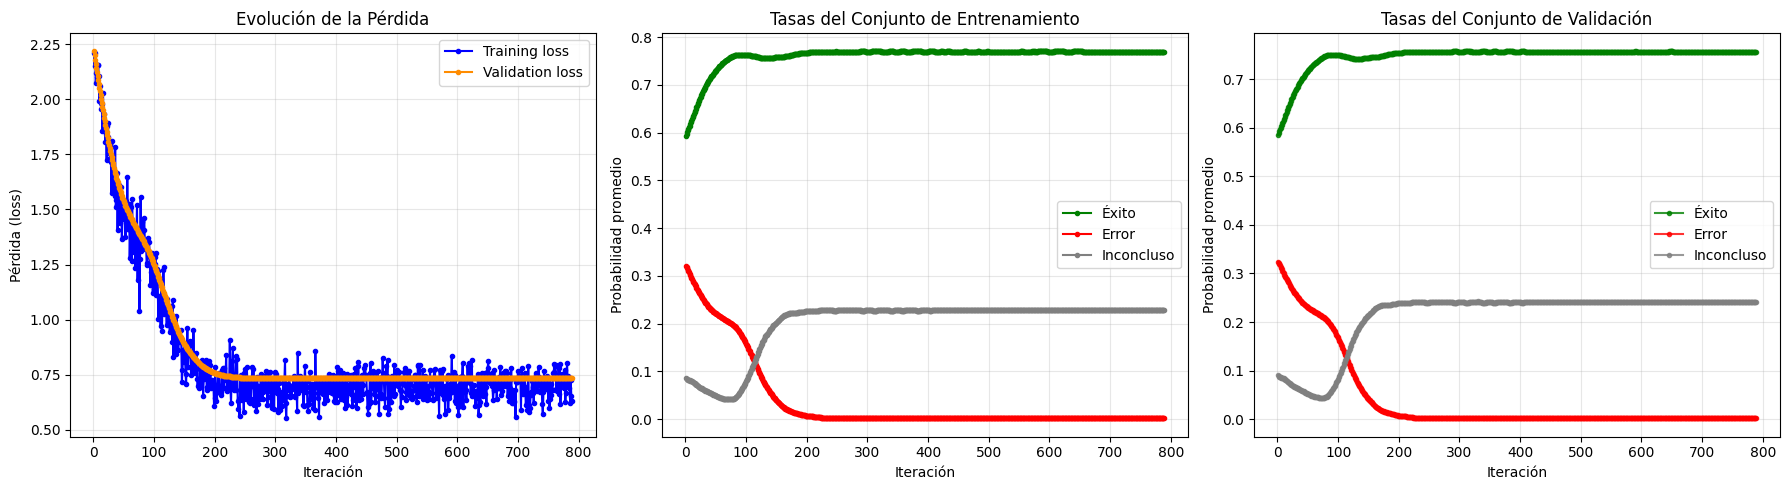

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

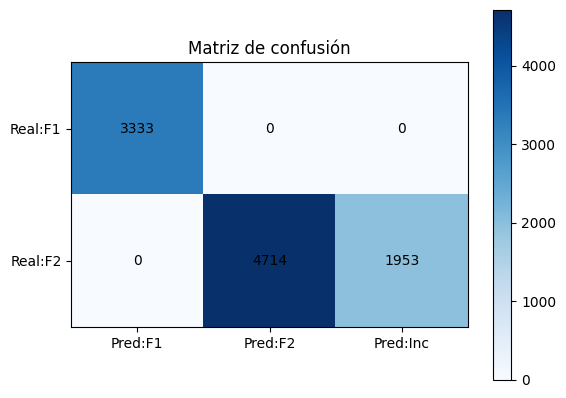

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
